#  Importance Sampling

##### Keywords: importance sampling, expectations, integration, sampling

## Contents
{:.no_toc}
* 
{: toc}

## Importance sampling with a purpose
We've already seen importance sampling as a mechanism for getting a weighted sample from some target distribution $f(x)$ by using an easier-to-sample-from proposal distribution $g(x)$. Further, we recognized that different $g(x)$ can be better or worse at approximating a particular $f(x)$.

In this notebook, note that often we want a sample _for a reason_, usually calculating an expectation. [Integrals are just expectations where the probability distribution is uniform]. We'll be diving deep and showing that importance sampling with a well-chosen $g(x)$ can mean we need FAR fewer samples to approximate the expectation than either a) a badly chosen $g(x)$ or b) using $f(x)$ itself!

#### The idea
Expectations, we recall, have two components: a score function and a probability distribution. We'll name these $h(x)$ and $f(x)$, respectively.

The standard approach is to build a representative sample from $f$, evaluate the score function at each point in the sample, and average. Importance sampling realizes that being representative of $f$ is no longer the key goal: why sample from regions of $f$ where the score function is basically zero? They won't matter much to the overall average. Sample from places where the score function is big.

Of course, we can't just sample places where the score function is large and call it a day: that would massively overestimate the integral. We'll need some kind of weighting that down-weights points we're sampling too much and up-weights points we're sampling too little.

Net: we're going to basically ignore $f$ as far as sampling and just sample according to $g$. When we average, we'll apply the score function to the samples from $g$, but also the importance sampling weights $\frac{f(x)}{g(x)}$. We'll shortly discuss how to choose a good $g$.

#### Details
Why is changing the thing we sample from important? Often, in the computation of an expectation or other integral, the integrand has a very small value on a dominant fraction of the whole integration volume.
If the points are chosen evenly in the integration volume, the small minority of the points close to the 'peak' give the dominant contribution to the integral.

For example lets look at the expectation

$$ E_f[h] = \int h(x) f(x) dx. $$

Choose a distribution $g(x)$, which is close to the function $f(x)$, but which is simple
enough so that it is possible to generate random $x$-values from this distribution.
The integral can now be re-written as:

$$ E_f[h] = \int h(x) g(x) \frac{f(x)}{g(x)} dx $$

Therefore if we choose random numbers $x_i$ from distribution $g(x)$, by LLN we obtain

$$ E_f[h] = \lim_{N\rightarrow \infty} \frac{1}{N} \sum_{x_{i}\sim g(.)} h(x_i)\frac{f(x_i)}{g(x_i)} $$

Usually you might have written:

$$E_f[h] = \lim_{N\rightarrow \infty} \frac{1}{N} \sum_{x_{i}\sim f(.)} h(x_i) $$

but now we have a reweighting with $w(x_i) =  \frac{f(x_i)}{g(x_i)}$ and the samples are drawn from $g(x)$:

$$ E_f[h] = \lim_{N\rightarrow \infty} \frac{1}{N} \sum_{x_{i}\sim g(.)} w(x_i) h(x_i) $$

Unlike rejection sampling we have used all samples!

Now remember that the variance of our montecarlo estimate is given to us by

$$\hat{V} = \frac{V_f[h(x)]}{N}$$

where $N$ is the sample size. 

With importance sampling this formula has now changed to

$$\hat{V} = \frac{V_g[w(x)h(x)]}{N}$$

Our game here now is to try and minimize  $V_g[w(x)h(x)]$.

As a somewhat absurd notion, this variance would be sent to zero, if:

$$w(x)h(x) = C \implies f(x) h(x) = C g(x),$$

which leads to (since g(x) is a density we must normalize)

$$g(x) = \frac{f(x)h(x)}{\int f(x) h(x) dx} = \frac{f(x)h(x)}{E_f[h(x)]}$$

The expectation was what we were trying to estimate in the first place so our tautological absurdity seems to grow..

But, ignoring the denominator, this formula tells us that to achieve low variance, we must have **$g(x)$ large where the product  $f(x)h(x)$ is large**.  After all,  maximizing the latter in some fashion was our original intuition. 

Or to put it another way, $\frac{g(x)}{f(x)}$ ought to be large where $h(x)$ is large. This means that, as we said earlier, choose more samples near the peak.

So now we have the ingredients of our method. We have a $f$ that we might or might not know. We have a pdf $g$ which we choose to be higher than $f$ at the points where $h$ has peaks. Now what we are left to do is to sample from $g$, and this will give us an oversampling at the place $h$ has peaks, and thus we must correct this there by multiplying by weights $w  = \frac{f}{g} \lt 1$ in thse places.

Be careful to choose $g(x)$ appropriately, it should have thicker tails than f, or the ratio $f/g$ will be too big and count contribute too much in the tails.

All of these considerations may be seen in the diagram below:

![](images/importance.png)

Another way of seeing this whole thing is that we will draw the sample from a proposal
distribution and re-weight the integral appropriately so that the expectation with respect to the correct distribution is used. And since $f/g$ is flatter than $f$, the variance of $h \times f/g$ is smaller that the variance of $h \times f$ and therefore the error will be smaller for all $N$.

### Example: Calculate $\int_{0}^{\pi} \sin(x) \, x \, dx $

The function has a shape that is similar to Gaussian and therefore we choose here a Gaussian as importance sampling distribution. 

In [5]:
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

mu = 2;
sig =.7;

f = lambda x: np.sin(x)*x
infun = lambda x: np.sin(x)-x*np.cos(x)
p = lambda x: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(x-mu)**2/(2.0*sig**2))
normfun = lambda x:  norm.cdf(x-mu, scale=sig)

Exact solution is:  3.14159265359
Mean basic MC estimate:  3.14042966769
Standard deviation of our estimates:  0.0635790401479
Mean importance sampling MC estimate:  3.14135105078
Standard deviation of our estimates:  0.0166034376556


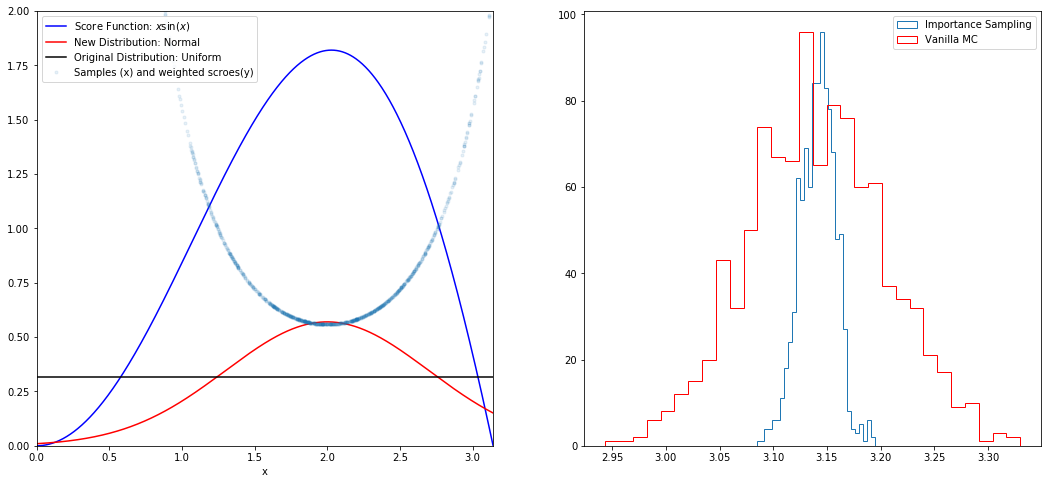

In [9]:
plt.figure(figsize=(18,8))  # set the figure size


# range of integration
xmax =np.pi 
xmin =0

# Number of draws 
N =1000

# Just want to plot the function
x=np.linspace(xmin, xmax, 1000)
plt.subplot(1,2,1)
plt.plot(x, f(x), 'b', label=u'Score Function: $x\sin(x)$')
plt.plot( x, p(x), 'r', label=u'New Distribution: Normal')
plt.plot(x, np.ones(1000)/np.pi,'k', label=u'Original Distribution: Uniform')
xis = mu + sig*np.random.randn(N,1);
plt.plot(xis, 1/(np.pi*p(xis)),'.', alpha=0.1, label=u"Samples (x) and weighted scroes (y)")
plt.xlim([0, np.pi])
plt.ylim([0,2])
plt.xlabel('x')
plt.legend()
# =============================================
# EXACT SOLUTION 
# =============================================
Iexact = infun(xmax)-infun(xmin)
print("Exact solution is: ", Iexact)

# ============================================
# VANILLA MONTE CARLO 
# ============================================
Ivmc = np.zeros(1000)
for k in np.arange(0,1000):
    x = np.random.uniform(low=xmin, high=xmax, size=N)
    Ivmc[k] = (xmax-xmin)*np.mean( f(x))

print("Mean basic MC estimate: ", np.mean(Ivmc))
print("Standard deviation of our estimates: ", np.std(Ivmc))

# ============================================
# IMPORTANCE SAMPLING 
# ============================================
# CHOOSE Gaussian so it similar to the original functions

Iis = np.zeros(1000)
for k in np.arange(0,1000):
    # DRAW FROM THE GAUSSIAN mean =2 std = sqrt(0.4) 
    xis = mu + sig*np.random.randn(N,1);
    #hist(x)
    xis = xis[ (xis<xmax) & (xis>xmin)] ;

    # normalization for gaussian from 0..pi
    normal = normfun(np.pi)-normfun(0);


    Iis[k] =np.mean(f(xis)/p(xis))*normal;

print("Mean importance sampling MC estimate: ", np.mean(Iis))
print("Standard deviation of our estimates: ", np.std(Iis))
plt.subplot(1,2,2)
plt.hist(Iis,30, histtype='step', label=u'Importance Sampling');
plt.hist(Ivmc, 30, color='r',histtype='step', label=u'Vanilla MC');
 
plt.legend();
 
 
 

In the left plot, we see that we shifted out proposal dsitribution from uniform to normal to better coincide with the score function. Points that are sampled more in the gaussian are down-weighted (weight below 1.0) and other points are up-weighted.

In the right plot, we see that for the same number of samples, the errors from importance sampling are MUCH smaller. Equivalently, to achieve the same accuracy a good importance sampler uses much less computation time than sampling from the original distribution.